# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

### Part 0 : Load the data</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
df.head(3)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074


In [3]:
df_content.head(3)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2


In [4]:
## Helper function provided by Udacity
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

In [5]:
unique_users_before = df.email.nunique()

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded
      
unique_users_after = df.user_id.nunique()

print(f'Length of dataframe before mapping {unique_users_before}')
print(f'Length of dataframe after mapping {unique_users_after}')

Length of dataframe before mapping 5148
Length of dataframe after mapping 5149


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

### Identify and remove duplicate content

In [6]:
is_duplicate_article = df_content.duplicated('article_id')
duplicate_article_ids = df_content[is_duplicate_article].article_id.values
df_content[df_content.article_id.isin(duplicate_article_ids)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [7]:
df_content.drop_duplicates(
    subset='article_id',
    keep='first',
    inplace=True
)

### How many articles do users interact with?

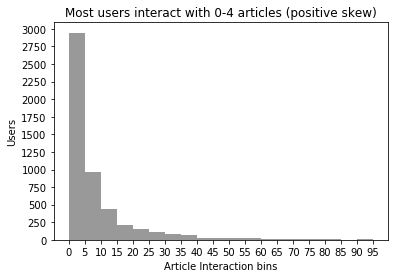

In [8]:
ax = sns.distplot(
    df.groupby('user_id')['article_id'].count().values,
    bins=[5*i for i in range(0,20)], 
    kde=False,
    color='black',
)

graph_params = {
    'title': 'Most users interact with 0-4 articles (positive skew)',
    'xlabel': 'Article Interaction bins',
    'ylabel': 'Users',
    'xticks': [5*i for i in range(0,20)],
    'yticks': [250*i for i in range(0,13)]
}

ax.set(**graph_params);

In [9]:
user_l_5_pc = sum(df.groupby('user_id')['article_id'].count().values < 5 ) / df.user_id.nunique()
user_geq_100_pc = sum(df.groupby('user_id')['article_id'].count().values >= 100 ) / df.user_id.nunique()

print(f'{round(user_l_5_pc*100,2)}% of users interact with less than five articles')
print(f'{round(user_geq_100_pc*100,2)}% of users interact with 100 or more articles')
print('\n')
print(df.groupby('user_id')['article_id'].count().describe())

57.21% of users interact with less than five articles
0.5% of users interact with 100 or more articles


count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


`2.` Use the cells below to find:

**a.** The median interactions for users. <br>
**b.** The most interactions made by a user.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [10]:
## Cell to test against Udacity results

unique_users = unique_users_before
unique_articles = df.article_id.nunique()
median_val = df.groupby('user_id')['article_id'].count().median()
total_articles = df_content.article_id.nunique()
user_article_interactions = len(df)
max_views_by_user = df.groupby('user_id')['article_id'].count().max()
most_viewed_article_id = str(df.article_id.value_counts().index[0])
max_views = df.article_id.value_counts().values[0]


print(f'''
Median article interactions: {median_val}
User article interactions: {user_article_interactions}
Max views by a user: {max_views_by_user}
Most viewed article_id: {most_viewed_article_id}
Amount of views: {max_views}
Unique articles with an interaction: {unique_articles}
Unique Users: {unique_users}
Unique Articles on IBM Platform: {total_articles}
''')


sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)


Median article interactions: 3.0
User article interactions: 45993
Max views by a user: 364
Most viewed article_id: 1429.0
Amount of views: 937
Unique articles with an interaction: 714
Unique Users: 5148
Unique Articles on IBM Platform: 1051

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_ids = get_top_article_ids(n, df)
    top_articles = [df[df.article_id == id].iloc[0].title for id in article_ids]
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    top_articles = df.article_id.value_counts().index[:n].tolist()
    return top_articles # Return the top article ids

In [12]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [13]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    one_hot = pd.get_dummies(df.article_id)

    merged = pd.merge(
        df, 
        one_hot, 
        left_index=True, 
        right_index=True
    )

    merged.drop(columns=['article_id', 'title'], inplace=True)

    user_item = merged.groupby('user_id').max()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [14]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [15]:
def calculate_similarity(x, y):
#     x_norm = np.linalg.norm(x)
#     y_norm = np.linalg.norm(y)
    return np.dot(x,y.transpose()) #/ (x_norm * y_norm)

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    x = user_item[user_item.index==user_id]
    result = user_item.apply(lambda y: calculate_similarity(x,y.transpose()), axis=1)
        
    # sort by similarity, create list of just the ids
    result = result.sort_values(ascending=False).index.tolist()
   
    # remove the own user's id
    most_similar_users = result[1:]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [46, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [17]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].title.unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_series = user_item[user_item.index==user_id].iloc[0]
    article_ids = article_series[article_series > 0].index.tolist()
    article_ids = [str(id) for id in article_ids] # test expects type == str
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    seen_articles, seen_titles = get_user_articles(user_id)
    similar_users = find_similar_users(user_id=user_id, user_item=user_item)

    recommendations = set()

    for user_id in similar_users:
        user_articles, user_titles = get_user_articles(user_id)
        new_recommendations = set(user_articles) - set(seen_articles)
        
        recommendations = recommendations | new_recommendations        
        if not len(recommendations) < m:
            break
    
    return list(recommendations)[:m]

In [18]:
# Check Results
x = get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

In [19]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [20]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    x = user_item[user_item.index==user_id]
    user_item = user_item[user_item.index != user_id]
    
    similarities = user_item.apply(
        lambda y: calculate_similarity(x,y)[0], 
        axis=1
    )
    
    interactions = user_item.apply(
        lambda r: sum(r),
        axis=1
    )
    
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarities': similarities.values,
        'interactions': interactions.values
    })

    neighbors_df.sort_values(
        by=['similarities', 'interactions'],
        ascending=[False,True], # Test expects [False, True] 
        inplace=True
    )
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    seen_articles, seen_titles = get_user_articles(user_id)

    similar_users_df = get_top_sorted_users(
        user_id=user_id,
        df=df,
        user_item=user_item
    )

    ranked_articles = df.groupby(['article_id', 'title'], as_index=False) \
        .count() \
        .sort_values(by='user_id', ascending=False)

    recommendations = []

    for user_id in similar_users_df.neighbor_id.values.tolist():
        user_articles, user_titles = get_user_articles(user_id)
        sorted_articles = ranked_articles[ranked_articles.article_id.isin(user_articles)].article_id.values.tolist()
        recommendations += [a for a in sorted_articles if a not in seen_articles + recommendations]
        
        if not len(recommendations) < m:
            break

    recommendation_titles = ranked_articles[ranked_articles.article_id.isin(recommendations)].title.values.tolist()
    
    return recommendations, recommendation_titles

In [21]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1293.0, 1162.0, 1185.0, 1165.0, 1320.0, 844.0, 254.0, 1271.0, 1328.0, 1410.0, 40.0, 232.0, 1402.0]

The top 10 recommendations for user 20 are the following article names:
['finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'classify tumors with machine learning', 'analyze precipitation data', 'housing (2015): united states demographic measures', 'income (2015): united states demographic measures', 'uci: sms spam collection', 'use the cloudant-spark connector in python notebook', 'ensemble learning to improve machine learning results', 'self-service data preparation with ibm data refinery', 'apple, ibm add machine learning to partnership with watson-core ml coupling', 'uci: adult - predict income']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [22]:
### Tests with a dictionary of results

user1_most_similar = int(get_top_sorted_users(1).iloc[0].neighbor_id) # Find the user that is most similar to user 1 
user131_10th_similar = int(get_top_sorted_users(131).iloc[9].neighbor_id) # Find the 10th most similar user to user 131

In [23]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_similar, 
    'The user that is the 10th most similar to user 131': user131_10th_similar,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**A:** Collaborative filtering relies on past interactions to recommend new content. New users will have zero or few interactions meaning there is little data to understand what content is useful for relevant to the user (this is referred to as the cold start problem and also applies to new content).

Inplace of our collaborative filtering engine we can make recommendations based on the top content available (based on some evaluation metric), in our case we can use the function `get_top_articles`. For content with zero interactions we can use content-based filtering to introduce the content to recommendations by showing the content alongside similar content.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [24]:
new_user = '0.0'
# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Your recommendations here
new_user_recs = get_top_article_ids(10, df=df)

In [25]:
new_user_recs = [str(r) for r in new_user_recs]
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [28]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [29]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [30]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In the lesson we looked at FunkSVD. FunkSVD is great for working with large sparse matricies, i.e. large matrices with missing values values represented by `nan`. The FunkSVD algorithm implements gradient descent to estimate missing values like ratings.

In our example we are not estimating ratings and have no missing values. The entries of the `user_item` matrix contains binary values which represent if a user has seen an article or not.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

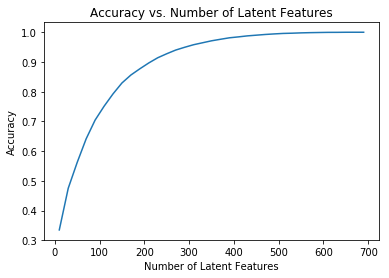

In [31]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [32]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)    
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = user_item_train.index
    test_idx = user_item_test.index
    
    train_arts = user_item_train.columns
    test_arts = user_item_test.columns
    
    user_int = np.intersect1d(train_idx, test_idx)
    art_int = np.intersect1d(train_arts, test_arts)

    user_item_test = user_item_test.loc[user_int, art_int]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [33]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

# Edit the solution dictionary because Udacity's test
# asserts "how many movies" instead of "how many articles"

sol_4_dict = {
    k.replace('articles', 'movies'):v
    for (k,v) in sol_4_dict.items()
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [34]:
u_train, s_train, vt_train = np.linalg.svd(np.array(user_item_train, dtype='int'), full_matrices=False)

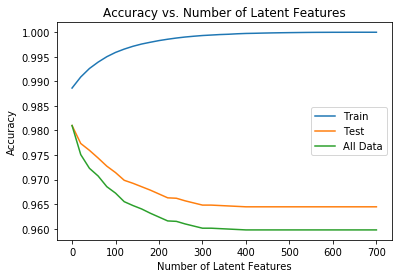

In [35]:
user_ids = user_item_train.index.isin(test_idx)
article_ids = user_item_train.columns.isin(test_arts)
u_test = u_train[user_ids, :]
vt_test = vt_train[:, article_ids]

# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(0,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lf, u_train_lf, vt_train_lf = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lf, vt_test_lf = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lf, s_train_lf), vt_train_lf))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lf, s_train_lf), vt_test_lf))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    # compute error for each prediction to actual value
    delta_train = np.subtract(user_item_train, user_item_train_preds)
    delta_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(delta_train)))
    err_test = np.sum(np.sum(np.abs(delta_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Train and test data**<br>
There are number of issues with the solution outlined in the notebook. Firstly, we have a small sample size to evaluate predicted recommendations with SVD since there are only 20 users in both the train and test dataset. Secondly the train and test dataset may make not be ordered by timestamp, this means we may use future interactions to predict historic ones.

**Predictions**<br>
The graph above shows that for in the training dataset the accuracy increases towards 100% as the number of latent features increases. The SVD is trying to estimate the training dataset so this is not surprising.

Fewer latent features lead to higher accuracies in the test dataset, this may be because of the large class imbalance. There are 218 article-user interactions across the 20 users and 574 articles. Predicting zero for all articles in the test set yields an acuracy of 98.1%.

**Next steps**

An experiment can be implemented to understand if the recommendation engine improves how users currently find articles (i.e. no recommendations). An exapmle null hypothesis is that the recommendation engine has no effect on the median number of articles visited in a month. An alternate hypothesis is that the recommendation engine imncreases the median number of articles visited in a month.

In [36]:
predict_zeros = np.zeros(shape=(20,574))
delta_test = np.subtract(user_item_test, predict_zeros)
err_test = np.sum(np.sum(np.abs(delta_test)))
accuracy = 1 - err_test / (user_item_test.shape[0]*user_item_test.shape[1])

print(f'Predict all zeros accuracy: {round(100*accuracy,2)}%')

Predict all zeros accuracy: 98.1%


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])